# Классификация фильмов по сложности восприятия английского языка

**Задача** 
Разработать ML решение для автоматического определения уровня сложности англоязычных фильмов

**Исходные данные**
Размеченный датасет с названиями фильмов, субтитрами и меткой уровня сложности языка ( A1/A2/B1/B2/C1/C2)

**Ход исследования**<br/>
 Открыть и загрузить исходные данные по ссылке: https://disk.yandex.ru/d/rQHuC6p6Ztf9Uw. Для обработки файла с субтитрами (формат srt) лучше использовать специализированную библиотеку pysrt https://github.com/byroot/pysrt. <br/>
 Провести EDA;<br/>
Попробовать расширить датасет, получив информацию из открытых источников;<br/>
 Изучить способы решения подобных задач (примеры: библиотеки по работе с NLP, лемматизация, стемминг и т.д.). Ознакомиться с необходимыми библиотеками и подходами для обработки текстов.<br/>
 Подготовить данные для обучения модели, выбрать метрику<br/>
 Собрать baseline модель, оценить качество вашего решения и попытаться улучшить его.<br/>

**Признаки**


**Целевой признак**
- Level — уровень владения английским языком

**Уровни владения английским языком**

В CEFR всего шесть уровней:

- `А1` и `А2` – элементарное владение

- `B1` и `B2` – самостоятельное владение

- `С1` и `С2` – свободное владение.

## Подготовка данных

Запрос сформирован тем, что просмотр фильмов на оригинальном языке это популярный и действенный метод прокачаться при изучении иностранных языков. Важно выбрать фильм, который подходит студенту по уровню сложности, т.ч. студент понимал 50 - 70 % диалогов. Чтобы выполнить это условие, преподаватель должен посмотреть фильм и решить, какому уровню он соответствует. Однако это требует больших временных затрат от преподавателя.

### Изучение данных

In [557]:

#блок загрузки бибилиотек
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pysrt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error

from catboost import CatBoostClassifier, Pool

from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

import textstat

RANDOM_STATE = 12345
pd.set_option('display.max_columns', None)


In [558]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Юля\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Юля\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Юля\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Юля\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [559]:
try:
    labels = pd.read_csv('/Users/Юля/Desktop/enlish/movies_labels.csv', sep=';')
except:
    labels = pd.read_csv('/Users/Юля/Desktop/enlish/movies_labels.csv', sep=';')
    
display(labels.head()) 

,id,Movie,Level
0,0,10_Cloverfield_lane(2016),B1
1,1,10_things_I_hate_about_you(1999),B1
2,2,A_knights_tale(2001),B2
3,3,A_star_is_born(2018),B2
4,4,Aladdin(1992),A2/A2+


In [560]:
# Загрузим предварительно сформированные данные о сложности слов согласно Оксфордского словаря
try:
    df_words = pd.read_csv('Oxsford_dikt.csv')
except:
    df_words = pd.read_csv('/Users/Юля/Desktop/enlish/oxford_dikt.csv')


    
display(df_words.head()) 

,diff,word
0,A1,improve
1,A1,potato
2,A1,night
3,A1,large
4,A1,come


In [561]:
# Загрузим предварительно сформированный список идиом
try:
    df_idioms = pd.read_csv('/Users/Юля/Desktop/enlish/theidioms_com.csv', sep='#')
except:
    df_idioms = pd.read_csv('/Users/Юля/Desktop/enlish/theidioms_com.csv', sep='#')
    
display(df_idioms.head()) 

,idiom,lem_idiom,meaning,example
0,drop a line,drop a line,send a brief letter.,"If you've got a few minutes to spare, you coul..."
1,win the day,win the day,to be accepted by other people.,"If you fail to win the day during practice, fo..."
2,the corridors of power,the corridor of power,the office of a powerful leader.,When Jim became a clerk to a Supreme Court jus...
3,by all means,by all mean,in every way possible.,"""Do you mind if I go to the party?"" ""By all me..."
4,piss and vinegar,piss and vinegar,to self-reference someone who is in a bad mood...,"During the invasion, the soldiers were full of..."


In [562]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      241 non-null    int64 
 1   Movie   241 non-null    object
 2   Level   241 non-null    object
dtypes: int64(1), object(2)
memory usage: 5.8+ KB


In [563]:
# переименование столбцов
labels=labels.rename(columns = {'Movie' : 'movie', 
                         'Level' : 'level'})

In [564]:
display(labels)
#labels.columns

,id,movie,level
0,0,10_Cloverfield_lane(2016),B1
1,1,10_things_I_hate_about_you(1999),B1
2,2,A_knights_tale(2001),B2
3,3,A_star_is_born(2018),B2
4,4,Aladdin(1992),A2/A2+
...,...,...,...
236,236,Matilda(2022),C1
237,237,Bullet train,B1
238,238,Thor: love and thunder,B2
239,239,Lightyear,B2


In [565]:
print(labels['level'])

0          B1
1          B1
2          B2
3          B2
4      A2/A2+
        ...  
236        C1
237        B1
238        B2
239        B2
240        B1
Name: level, Length: 241, dtype: object


In [566]:
# распределение фильмов по уровням сложности
labels['level'].value_counts()

B2            101
B1             55
C1             40
A2/A2+         26
B1, B2          8
A2              6
A2/A2+, B1      5
Name: level, dtype: int64

In [567]:
# для упрощения градаций преобразуем уровни сложности до минимального
labels.loc[labels.level == 'A2/A2+', 'level'] = 'A2'
labels.loc[labels.level == 'B1, B2', 'level'] = 'B1'
labels.loc[labels.level == 'A2/A2+, B1', 'level'] = 'A2'

In [568]:
# распределение фильмов по уровням сложности
labels['level'].value_counts()

B2    101
B1     63
C1     40
A2     37
Name: level, dtype: int64

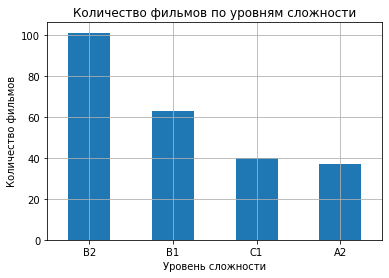

In [569]:
# график количества фильмов в датасете по уровням сложности
labels['level'].value_counts().plot(
    kind='bar', title='Количество фильмов по уровням сложности', grid=True,
    xlabel='Уровень сложности', ylabel='Количество фильмов', rot=0
);

In [570]:
# папка с файлами субтитров
srt_path = '/Users/Юля/Desktop/enlish/Subtitles_all/subtitles_all'
#C:\Users\Юля\Desktop\enlish\Subtitles_all\subtitles_all

In [571]:
# получим список файлов с субтитрами
srt_files = os.listdir(srt_path)

# первые 5 файлов
srt_files[:5]

['.DS_Store',
 '10_Cloverfield_lane(2016).srt',
 '10_things_I_hate_about_you(1999).srt',
 'Aladdin(1992).srt',
 'All_dogs_go_to_heaven(1989).srt']

In [572]:
# функция сопоставления названия фильма и имени файла субтитров
def fill_file_path(movie):
    """
    функция по названию фильма ищет соответствующее имя файла
    и возвращает его, иначе, возвращает пустую строку
    """
    file_path = ''
    # ищем соответсвующее имя файла в списке
    for i in range(len(srt_files)):
        file = srt_files[i]
        # если есть совпадение
        if file.find(movie) >= 0:
            file_path = os.path.join(srt_path, srt_files[i])
    return file_path

In [573]:
# функция сопоставления названия фильма и имени файла субтитров
def fill_file_name(movie):
    """
    функция по названию фильма ищет соответствующее имя файла
    и возвращает его, иначе, возвращает пустую строку
    """
    file_name = ''
    # ищем соответсвующее имя файла в списке
    for i in range(len(srt_files)):
        file = srt_files[i]
        # если есть совпадение
        if file.find(movie) >= 0:
            file_name = srt_files[i]
    return file_name

In [574]:
# проверим работу функции
fill_file_name('Suits.S03E10.HDTV.x264-mSD')

'Suits.S03E10.HDTV.x264-mSD.srt'

In [575]:
# проверим работу функции
fill_file_path('Suits.S03E10.HDTV.x264-mSD')

'/Users/Юля/Desktop/enlish/Subtitles_all/subtitles_all\\Suits.S03E10.HDTV.x264-mSD.srt'

In [576]:
# копируем названия фильмов в новую колонку
labels['file'] = labels['movie']

In [577]:
display(labels)

,id,movie,level,file
0,0,10_Cloverfield_lane(2016),B1,10_Cloverfield_lane(2016)
1,1,10_things_I_hate_about_you(1999),B1,10_things_I_hate_about_you(1999)
2,2,A_knights_tale(2001),B2,A_knights_tale(2001)
3,3,A_star_is_born(2018),B2,A_star_is_born(2018)
4,4,Aladdin(1992),A2,Aladdin(1992)
...,...,...,...,...
236,236,Matilda(2022),C1,Matilda(2022)
237,237,Bullet train,B1,Bullet train
238,238,Thor: love and thunder,B2,Thor: love and thunder
239,239,Lightyear,B2,Lightyear


In [578]:
labels['file_path'] = labels['movie'].apply(fill_file_path)

In [579]:
# применяем функцию для заполнения
#labels['file_path'] = labels['movie'].apply(fill_file_path)
labels['file_name'] = labels['movie'].apply(fill_file_name)

In [580]:

# результат заполнения
labels.head()

,id,movie,level,file,file_path,file_name
0,0,10_Cloverfield_lane(2016),B1,10_Cloverfield_lane(2016),/Users/Юля/Desktop/enlish/Subtitles_all/subtit...,10_Cloverfield_lane(2016).srt
1,1,10_things_I_hate_about_you(1999),B1,10_things_I_hate_about_you(1999),/Users/Юля/Desktop/enlish/Subtitles_all/subtit...,10_things_I_hate_about_you(1999).srt
2,2,A_knights_tale(2001),B2,A_knights_tale(2001),/Users/Юля/Desktop/enlish/Subtitles_all/subtit...,A_knights_tale(2001).srt
3,3,A_star_is_born(2018),B2,A_star_is_born(2018),/Users/Юля/Desktop/enlish/Subtitles_all/subtit...,A_star_is_born(2018).srt
4,4,Aladdin(1992),A2,Aladdin(1992),/Users/Юля/Desktop/enlish/Subtitles_all/subtit...,Aladdin(1992).srt


In [581]:
print(labels['file_path'])

0      /Users/Юля/Desktop/enlish/Subtitles_all/subtit...
1      /Users/Юля/Desktop/enlish/Subtitles_all/subtit...
2      /Users/Юля/Desktop/enlish/Subtitles_all/subtit...
3      /Users/Юля/Desktop/enlish/Subtitles_all/subtit...
4      /Users/Юля/Desktop/enlish/Subtitles_all/subtit...
                             ...                        
236                                                     
237                                                     
238                                                     
239                                                     
240                                                     
Name: file_path, Length: 241, dtype: object


In [582]:

labels[labels['file'] == '']

,id,movie,level,file,file_path,file_name


In [583]:

labels[labels.file.duplicated(keep=False)].sort_values('file')

,id,movie,level,file,file_path,file_name
43,43,Inside_out(2015),B1,Inside_out(2015),/Users/Юля/Desktop/enlish/Subtitles_all/subtit...,Inside_out(2015).srt
44,44,Inside_out(2015),B1,Inside_out(2015),/Users/Юля/Desktop/enlish/Subtitles_all/subtit...,Inside_out(2015).srt
38,38,Powder(1995),B1,Powder(1995),/Users/Юля/Desktop/enlish/Subtitles_all/subtit...,Powder(1995).srt
68,68,Powder(1995),B1,Powder(1995),/Users/Юля/Desktop/enlish/Subtitles_all/subtit...,Powder(1995).srt
75,75,The_blind_side(2009),B2,The_blind_side(2009),/Users/Юля/Desktop/enlish/Subtitles_all/subtit...,The_blind_side(2009).srt
84,84,The_blind_side(2009),B1,The_blind_side(2009),/Users/Юля/Desktop/enlish/Subtitles_all/subtit...,The_blind_side(2009).srt
83,83,The_terminal(2004),B1,The_terminal(2004),/Users/Юля/Desktop/enlish/Subtitles_all/subtit...,The_terminal(2004).srt
99,99,The_terminal(2004),A2,The_terminal(2004),/Users/Юля/Desktop/enlish/Subtitles_all/subtit...,The_terminal(2004).srt


In [584]:

labels.drop_duplicates()

,id,movie,level,file,file_path,file_name
0,0,10_Cloverfield_lane(2016),B1,10_Cloverfield_lane(2016),/Users/Юля/Desktop/enlish/Subtitles_all/subtit...,10_Cloverfield_lane(2016).srt
1,1,10_things_I_hate_about_you(1999),B1,10_things_I_hate_about_you(1999),/Users/Юля/Desktop/enlish/Subtitles_all/subtit...,10_things_I_hate_about_you(1999).srt
2,2,A_knights_tale(2001),B2,A_knights_tale(2001),/Users/Юля/Desktop/enlish/Subtitles_all/subtit...,A_knights_tale(2001).srt
3,3,A_star_is_born(2018),B2,A_star_is_born(2018),/Users/Юля/Desktop/enlish/Subtitles_all/subtit...,A_star_is_born(2018).srt
4,4,Aladdin(1992),A2,Aladdin(1992),/Users/Юля/Desktop/enlish/Subtitles_all/subtit...,Aladdin(1992).srt
...,...,...,...,...,...,...
236,236,Matilda(2022),C1,Matilda(2022),,
237,237,Bullet train,B1,Bullet train,,
238,238,Thor: love and thunder,B2,Thor: love and thunder,,
239,239,Lightyear,B2,Lightyear,,


In [585]:
# Кодируем целевую переменную
targets = {
           'A1':1, 
           'A2':2,
           'B1':3,
           'B2':4,
           'C1':5,
           'C2':6
           }
labels['target'] = labels['level'].apply(lambda x: targets[x])

## Парсинг субтитров

In [598]:
labels.head(2)

,id,movie,level,file,file_path,file_name,target
0,0,10_Cloverfield_lane(2016),B1,10_Cloverfield_lane(2016),/Users/Юля/Desktop/enlish/Subtitles_all/subtit...,10_Cloverfield_lane(2016).srt,3
1,1,10_things_I_hate_about_you(1999),B1,10_things_I_hate_about_you(1999),/Users/Юля/Desktop/enlish/Subtitles_all/subtit...,10_things_I_hate_about_you(1999).srt,3


In [600]:
wnl = WordNetLemmatizer()

In [601]:
def sub_processing(filename):
    """ Принимаем имя файла субтитров
        Возвращаем список параметров расчитаных на основе обработки файла
    """
    # читаем файл субтитров
    try:
        subs = pysrt.open('/Users/Юля/Desktop/enlish/Subtitles_all/subtitles_all/'+ filename)
    except:
        subs = pysrt.open('/Users/Юля/Desktop/enlish/Subtitles_all/subtitles_all/'+ filename, encoding='latin-1')
        #'/Users/Юля/enlish/Subtitles_all/subtitles_all/'
        
    # Время начала фильма
    film_start = subs[0].start.hours*3600 + subs[0].start.minutes*60 + subs[0].start.seconds
    # Время окончания фильма
    if subs[-1].index - subs[-2].index < 2:
        film_end = subs[-1].end.hours*3600 + subs[-1].end.minutes*60 + subs[-1].end.seconds
    else:
        film_end = subs[-2].end.hours*3600 + subs[-2].end.minutes*60 + subs[-2].end.seconds\
    # Продолжительность фильма
    film_start, film_end = min(film_start, film_end), max(film_start, film_end)
    film_lenght = film_end - film_start
        
    # Очистка текста
    # text = re.sub('<i>|</i>', '', subs.text)
    text = re.sub('\<.*?\>', '', subs.text)      # удаляем то что в скобках <>
    text = re.sub('\n', ' ', text)               # удаляем разделители строк    
    # text = re.sub('<font.*?font>', '', text)
    text = re.sub('\(.*?\)', '', text)           # удаляем то что в скобках ()    
    text = re.sub('\[.*?\]', '', text)           # удаляем то что в скобках []
    text = re.sub('[A-Z]+?:', '', text)          # удаляем слова написанные заглавными буквами с двоеточием(это имена тех кто говорит)
    text = re.sub('\.+?:', '\.', text)           # Заменяем троеточия на одну точку
    text = text.lower()
    text = re.sub('[^a-z\.\!\?]', ' ', text)     # удаляем всё что не буквы и не .?!
    text = re.sub(' +', ' ', text)               # удаляем " +"
    # text = re.sub(r'\n ', '', text)
     
    # Количество предложений
    num_sentence = len(re.split('[\.\?\!]', text))
    
    # морфологический разбор
    morphs = [_[1] for _ in nltk.pos_tag(re.sub('\n', ' ', text).lower().split(' '))]
    # Герундий
    gerund = morphs.count('VBG')
    
    text_no_preproc = text
    text = re.sub('[^a-z]', ' ', text)     # удаляем всё что не буквы
    
    # ищем идиомы
    num_idioms = 0
    for idiom in df_idioms['lem_idiom']:
        match = re.finditer(fr'{idiom}', text)
        num_idioms += len([_ for _ in match])
    
    # Количество символов
    text_len = len(text)
    # Букв в секунду
    sumb_persecond = text_len / film_lenght
    
    # # Избавимся от стоп-слов
    # for stop_word in nltk_stopwords.words('english'):
    #     text = re.sub(f' {stop_word} ', ' ', text)
        
    # удалим однобуквенные слова
    text = re.sub(' [a-z] ', ' ', text)
    text = re.sub(' [a-z] ', ' ', text)
    text = re.sub(' [a-z] ', ' ', text)
    
    text_no_lem = text
    
     # Список уникальных слов
    words = text.split(' ')
    words_unique = []
    for word in words:
        if word not in words_unique:
            words_unique.append(word)
    
    sumb_perword = (text_len - len(words)) / len(words)
        
    # Расчитаем количество слов разной сложности в фильме 
    difficulty = {'A1':0,
                  'A2':0,
                  'B1':0,
                  'B2':0,
                  'C1':0,
                  'C2':0
                 }
    
    for word in words_unique:
        match = df_words[df_words['word'] == word]['diff'].values
        if len(match) > 0:
            for dif in match:
                difficulty[dif] += 1
       
   
    text = ' '.join([wnl.lemmatize(word, wordnet.VERB) for word in text.split(' ')])
    
    # Посчитаем продолжительность всех фраз
    phrases_lenght = 0
    for sub in subs:
         # Время начала фразы
        phrase_start = sub.start.hours*3600 + sub.start.minutes*60 + sub.start.seconds
        # Время окончания фразы
        phrase_end = sub.end.hours*3600 + sub.end.minutes*60 + sub.end.seconds
        # Продолжительность фразы
        phrases_lenght += max(0, phrase_end - phrase_start)
    
    sumb_persecond_frases = text_len / phrases_lenght
    
    # Возвращаем результаты
    return [film_lenght,
            text_len, 
            len(text),
            sumb_persecond, 
            phrases_lenght,
            sumb_persecond_frases,
            sumb_perword,
            max(num_sentence, len(subs)),
            len(words) / max(num_sentence, len(subs)),
            difficulty['A1']/len(words_unique),
            difficulty['A2']/len(words_unique),
            difficulty['B1']/len(words_unique),
            difficulty['B2']/len(words_unique),
            difficulty['C1']/len(words_unique),
            difficulty['C2']/len(words_unique),
            len(subs),
            len(words_unique) / len(subs),
            len(words),
            len(words_unique),
            len(words_unique) / film_lenght,
            len(words_unique) / len(words),
            textstat.flesch_reading_ease(text_no_preproc),
            textstat.flesch_kincaid_grade(text_no_preproc),
            textstat.smog_index(text_no_preproc),
            textstat.coleman_liau_index(text_no_preproc),
            textstat.automated_readability_index(text_no_preproc),
            textstat.dale_chall_readability_score(text_no_preproc),
            textstat.difficult_words(text_no_preproc),
            textstat.linsear_write_formula(text_no_preproc),
            textstat.gunning_fog(text_no_preproc),
            textstat.text_standard(text_no_preproc),
            textstat.fernandez_huerta(text_no_preproc),
            textstat.szigriszt_pazos(text_no_preproc),
            textstat.gutierrez_polini(text_no_preproc),
            textstat.crawford(text_no_preproc),
            textstat.gulpease_index(text_no_preproc),
            textstat.osman(text_no_preproc),
            num_idioms,
            gerund,
            gerund / num_sentence, 
            text,
            text_no_lem,
            ' '.join(morphs)
           ]

In [ ]:
%%time
new_columns = ['film_lenght', 
               'text_len', 
               'lematise_text_len', 
               'sumb_persecond',
               'phrases_lenght',
               'sumb_persecond_frases',
               'sumb_perword',
               'num_sentence',
               'word_persentence',
               'A1',
               'A2',
               'B1',
               'B2',
               'C1',
               'C2',
               'phrases_count',
               'words_unique_perphrase', 
               'words_count',
               'words_unique_count',
               'words_unique_persecond',
               'lexical_diversity',
               'flesch_reading_ease',
               'flesch_kincaid_grade',
               'smog_index',
               'coleman_liau_index',
               'automated_readability_index',
               'dale_chall_readability_score',
               'difficult_words',
               'linsear_write_formula',
               'gunning_fog',
               'text_standard',
               'fernandez_huerta',
               'szigriszt_pazos',
               'gutierrez_polini',
               'crawford',
               'gulpease_index',
               'osman',
               'num_idioms',
                'gerund',
                'gerund_persentence', 
               'text',
               'text_no_lem',
               'morphs'
              ]

labels.loc[~labels['file_name'].isna(), new_columns] = [_ for _ in labels.loc[~labels['file_name'].isna(), 'file_name'].apply(sub_processing)]
labels.head()

In [ ]:
labels['avg_dificulty'] = labels[['A1','A2','B1','B2','C1','C2']].apply(lambda x: np.mean([x['A1'], x['A2']*1.5, x['B1']*5, x['B2']*50, x['C1']*500, x['C2']*750]) ,axis=1)


In [ ]:
labels['idioms_persentence'] = labels['num_idioms'] / labels['num_sentence'] 

**Вывод:**

Файлы субтитров обработаны. Извлечены признаки из текста субтитров.



## Анализ данных

проанализируем полученные признаки

In [ ]:
#pivot_table = labels[labels['level'].isin(['A1', 'A2', 'B1', 'B2', 'C1', 'C2'])].groupby('level').mean()
#pivot_table

In [ ]:
#plt.rcParams['figure.figsize']=(30,30)
#sns.heatmap(labels[labels['target'] != 0].corr(), square=True, annot=True);

In [ ]:
#sns.pairplot(data=labels[['A1','A2','B1','B2','C1','C2','target']], hue='target');

## Построение модели машинного обучения

Модель: CatBoostClassifier
Набор признаков:
- phrases_lenght - средняя длина фразы
- B2 - доля уникальных слов сложности B2
- coleman_liau_index - уровень качества текста по формуле Коулмана-Лиау
- word_persentence - среднее количество слов во фразе
- gulpease_index - индекс текста Gulpease(вообще он для итальянского текста, но подошел и к английскому)
- gerund_persentence - среднее количество герундия во фразе
- words_unique_perphrase - среднее количество уникальных слов во фразе
- words_unique_persecond - среднее количество уникальных слов в секунду
- phrases_count - количество фраз в тексте
- avg_dificulty - средняя сложность слов
- idioms_persentence - среднее количество идиом во фразе

Кодировка текста производилась внутренним алгоритмом модели CatBoostClassifier. А в качестве текста выступали морфологические формы слов.

### Подготовка выборок

Разделим датасет на тренировочную и тестовую выборки.
Обучим модель и подберём гиперпараметры
Протестируем модель

In [ ]:
effective_features =[
        'movie',
        'phrases_lenght', 
        'B2', 
        'coleman_liau_index', 
        'word_persentence', 
        'gulpease_index', 
        'gerund_persentence', 
        'words_unique_perphrase', 
        'words_unique_persecond',
        'phrases_count',
        'target',
        'avg_dificulty',
        'idioms_persentence',
]

In [ ]:
features = labels[effective_features].set_index('movie').copy()

X = features.drop(columns=['target'])
y = features['target']

In [ ]:
X_train, X_tv, y_train, y_tv = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
X_valid, X_test, y_valid, y_test = train_test_split(X_tv, y_tv, test_size=0.5, random_state=RANDOM_STATE)
print('Размер тренировочной выборки - {:.0%}'.format(X_train.shape[0]/X.shape[0]))
print('Размер валидационной выборки - {:.0%}'.format(X_valid.shape[0]/X.shape[0]))
print('Размер тестовой выборки - {:.0%}'.format(X_test.shape[0]/y.shape[0]))

In [ ]:
# Для модели CatBoostClassifier сформируем пулы
# Тренировочный пул
train_pool = Pool(data=X_train,
                  label=y_train,
                 )
# Валидационный пул
valid_pool = Pool(data=X_valid,
                   label=y_valid,
                  )
# Тестовый пул
test_pool = Pool(data=X_test,
                   label=y_test,
                  )

# Тренировочный + Валидационный пул
learn_pool = Pool(data=pd.concat([X_train, X_valid]),
                  label=pd.concat([y_train, y_valid])
                 )

Так как датасет имеет совсем небольшой размер, модель градиентного бустинга очень легко переобучается. Поэтому было решено в качестве индикатора переобучения использовать валидационную выборку.

In [ ]:
def fit_model(train_pool, valid_pool, **kwargs):
    """ Принимаем тренировочный и тестовый пул, а также параметры модели.
        Возвращаем обученную модель
    """
    model = CatBoostClassifier(
                               eval_metric='TotalF1',
                               od_type='Iter',
                               od_wait=500,
                               tokenizers=
                                     [{'tokenizer_id': 'Sense',
                                       'separator_type': 'BySense',
                                       'lowercasing': 'True',
                                       'token_types':['Word', 'Number', 'SentenceBreak'],
                                       'sub_tokens_policy':'SeveralTokens'
                                      }],
                                     dictionaries = [{'dictionary_id': 'Word','max_dictionary_size': '1000'}],
                                     feature_calcers = ['BoW:top_tokens_count=1000'],
                               **kwargs
                              )
    return model.fit(train_pool,
                     eval_set=valid_pool,
                     verbose=100,
                     plot=True,
                     use_best_model=True)

In [ ]:
%%time
# Обучаем модель
model = fit_model(train_pool,
                  valid_pool,
                  learning_rate=0.1,
                  n_estimators=200,
                  max_depth=10,
                  l2_leaf_reg=1e-08
                )

In [ ]:
preds = model.predict(valid_pool)
accuracy_score(preds, y_valid)

## Тестирование модели

- Протестируем модель на тестовой выборке и сохраним обученную модель для дальнейшего использования в скрипте микросервиса.
- Сравним работу модели с фиктивной моделью.
- Оценим важность признаков

In [ ]:
preds = model.predict(test_pool)
accuracy_score(preds, y_test)

In [ ]:
%%time
# Обучаем модель
model = fit_model(learn_pool,
                  test_pool,
                  learning_rate=0.1,
                  n_estimators=200,
                  max_depth=10,
                  l2_leaf_reg=1e-08
                 )

In [ ]:
# Сохраним обученную модель для дальнейшего использования
model.save_model('catboostclassifier_model.cbm')